In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
!pip install tensorflow numpy pandas matplotlib seaborn opencv-python tqdm scikit-learn --quiet

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Input, Conv2D

In [ ]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
else:
    print("Using CPU")

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Using GPU
Num GPUs Available:  1


In [ ]:
disease_types = ['Bacterial Leaf Disease','Fungal Brown Spot Disease','Dried Leaf','Healthy Leaf']
# disease_types = ['Bacterial Leaf Disease','Fungal Brown Spot Disease']

# data_dir = '/content/drive/MyDrive/Betal Leaf_Project/temp_Images'
data_dir = '/kaggle/input/betal-leaf/Updated_aug'
train_dir = os.path.join(data_dir)
# test_dir = os.path.join(data_dir, 'test')

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head(3)

,File,DiseaseID,Disease Type
0,Bacterial Leaf Disease/Bacterial_Leaf_Spot_Dis...,0,Bacterial Leaf Disease
1,Bacterial Leaf Disease/Bacterial_Leaf_Spot_Dis...,0,Bacterial Leaf Disease
2,Bacterial Leaf Disease/Bacterial_Leaf_Spot_Dis...,0,Bacterial Leaf Disease


In [ ]:
len(train_data)

10000

In [ ]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Dried Leaf/Dried_Leaf(178)_aug_4.jpg,2,Dried Leaf
1,Fungal Brown Spot Disease/Fungal_Brown_Spot_Di...,1,Fungal Brown Spot Disease
2,Bacterial Leaf Disease/Bacterial_Leaf_Spot_Dis...,0,Bacterial Leaf Disease
3,Fungal Brown Spot Disease/Fungal_Brown_Spot_Di...,1,Fungal Brown Spot Disease
4,Fungal Brown Spot Disease/Fungal_Brown_Spot_Di...,1,Fungal Brown Spot Disease


In [ ]:
IMAGE_SIZE = 224

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = image

10000it [01:09, 144.07it/s]


In [ ]:
X_train = X_train / 255.0
print('Train Shape: {}'.format(X_train.shape))

Train Shape: (10000, 224, 224, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=4)

In [ ]:
BATCH_SIZE = 64

# Split the train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=SEED)

In [ ]:
EPOCHS = 100
SIZE=224
N_ch=3

# Densenet

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_densenet():
    # Load the DenseNet201 model without the top layer
    densenet = DenseNet201(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, N_ch))

    # Input layer
    input_layer = Input(shape=(SIZE, SIZE, N_ch))

#     # Pass through DenseNet201
#     x = densenet(input_layer)

    # Initial Conv layer to adjust for input channels
    x = Conv2D(3, (5, 5), padding='same', activation='relu')(input_layer)

    # Pass through DenseNet201
    x = densenet(x)

    x = Conv2D(128, (5, 5), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Dense layers for classification
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer for 4 classes
    output = Dense(4, kernel_regularizer=l2(0.01), activation='softmax', name='root')(x)

    # Create the model
    model = Model(input_layer, output)

    # Compile the model
    optimizer = Adam(learning_rate=1e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Build the model
model = build_densenet()



74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 3)    │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │     6,144,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ root (Dense)                    │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,132,456 (95.87 MB)

 Trainable params: 24,899,816 (94.99 MB)

 Non-trainable params: 232,640 (908.75 KB)

None


In [ ]:
from sklearn.utils import class_weight

y_train_indices = np.argmax(Y_train, axis=1)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_indices),
    y=y_train_indices
)

class_weights = {i: class_weights[i] for i in range(len(class_weights))}


In [ ]:

annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, verbose=5, min_lr=1e-5)
checkpoint = ModelCheckpoint('model.keras', verbose=1, save_best_only=True)


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [ ]:
for layer in model.layers[-20:]:
    layer.trainable = True

model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)


In [ ]:
hist = model.fit(
    datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=2,
    callbacks=[annealer, checkpoint, early_stopping],
    validation_data=(X_val, Y_val),
    class_weight=class_weights,
    shuffle=True
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727753773.291542      78 service.cc:145] XLA service 0x7bfa080095d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727753773.291607      78 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727754028.260965      78 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_80', 4 bytes spill stores, 20 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_82', 8 bytes spill stores, 48 bytes spill loads
pt

125/125 - 512s - 4s/step - accuracy: 0.7369 - loss: 0.8360 - val_accuracy: 0.5545 - val_loss: 1.1812 - learning_rate: 1.0000e-04
Epoch 2/100


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


125/125 - 5s - 43ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5545 - val_loss: 1.1812 - learning_rate: 1.0000e-04
Epoch 3/100
125/125 - 102s - 813ms/step - accuracy: 0.9093 - loss: 0.3482 - val_accuracy: 0.7840 - val_loss: 0.6098 - learning_rate: 1.0000e-04
Epoch 4/100
125/125 - 5s - 42ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7840 - val_loss: 0.6098 - learning_rate: 1.0000e-04
Epoch 5/100
125/125 - 102s - 817ms/step - accuracy: 0.9440 - loss: 0.2380 - val_accuracy: 0.8550 - val_loss: 0.4936 - learning_rate: 1.0000e-04
Epoch 6/100
125/125 - 5s - 43ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8550 - val_loss: 0.4936 - learning_rate: 1.0000e-04
Epoch 7/100
125/125 - 102s - 814ms/step - accuracy: 0.9640 - loss: 0.1805 - val_accuracy: 0.9675 - val_loss: 0.1651 - learning_rate: 1.0000e-04
Epoch 8/100
125/125 - 5s - 43ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9675 - val_loss: 0.1651 - learning_r

In [ ]:
# model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.9938 - loss: 0.0497
Final Loss: 0.04508312791585922, Final Accuracy: 0.9955000281333923


63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 337ms/step


Text(0.5, 192.72222222222217, 'Predicted')

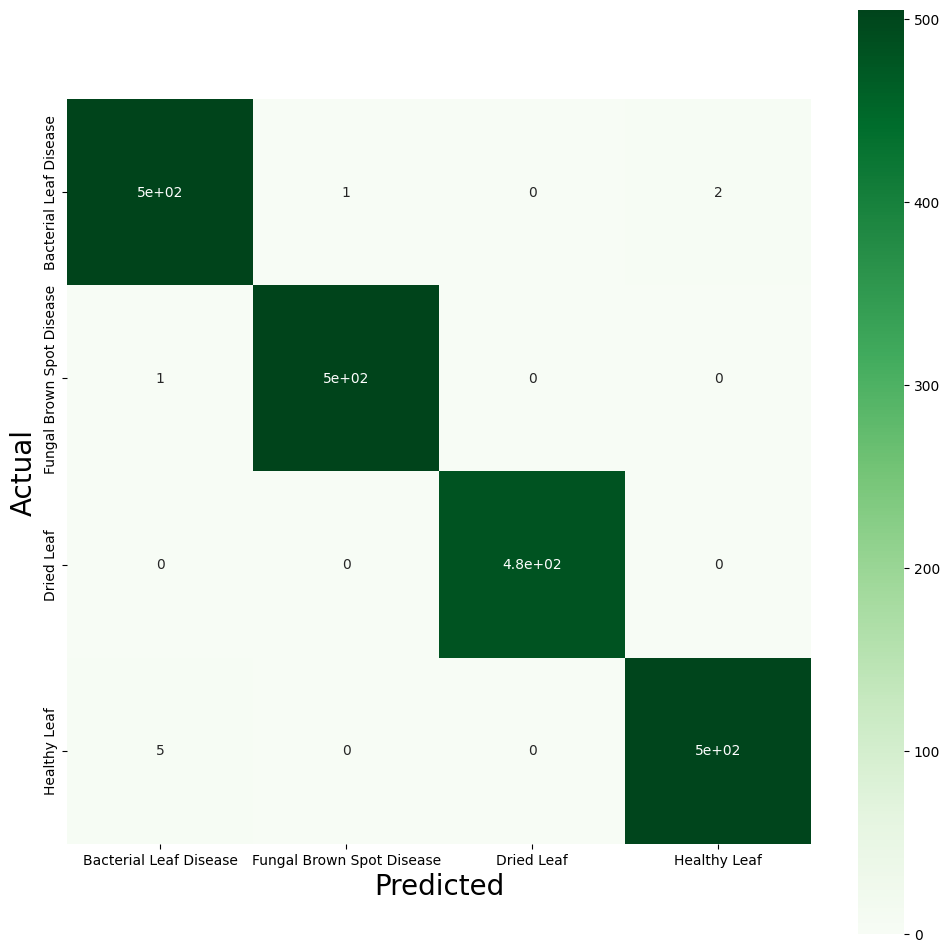

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(Y_true, Y_pred, target_names=disease_types)
print(report)

                           precision    recall  f1-score   support

   Bacterial Leaf Disease       0.99      0.99      0.99       507
Fungal Brown Spot Disease       1.00      1.00      1.00       506
               Dried Leaf       1.00      1.00      1.00       480
             Healthy Leaf       1.00      0.99      0.99       507

                 accuracy                           1.00      2000
                macro avg       1.00      1.00      1.00      2000
             weighted avg       1.00      1.00      1.00      2000



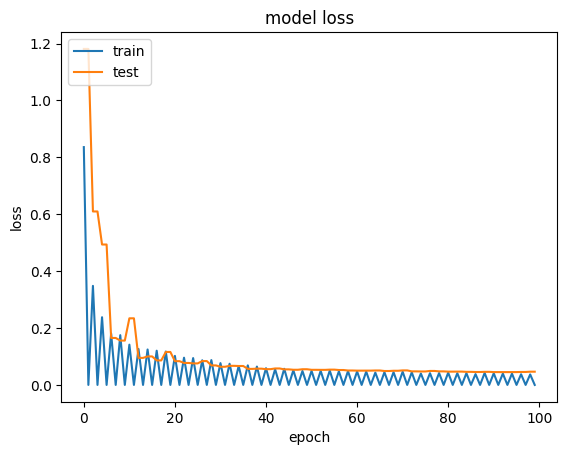

In [ ]:
# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# GRADCAM

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2



In [ ]:
def load_and_preprocess_image(image_path, image_size):
    # Load the image in RGB format
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = tf.keras.applications.densenet.preprocess_input(x)
    return x

In [ ]:
def get_model_layers(model):
    last_conv_layer = model.get_layer('conv2d_1')
    output_layer = model.get_layer('dense')
    return last_conv_layer, output_layer


In [ ]:
def generate_grad_cam_heatmap(img_path, model, last_conv_layer, output_layer):
    img = load_and_preprocess_image(img_path, model.input_shape[1:3])
    img = np.expand_dims(img, axis=0)

    preds = model.predict(img)
    class_index = np.argmax(preds[0])
    class_output = model.output[:, class_index]

    grads = tf.keras.backend.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = tf.keras.backend.mean(grads, axis=(0, 1, 2))

    iterate = tf.keras.backend.function([model.input], [last_conv_layer.output, pooled_grads, output_layer.output])
    conv_output, grad_values, predictions = iterate([img])

    weights = np.mean(grad_values, axis=0)
    cam = np.dot(conv_output[0], weights)

    cam = cv2.resize(cam, model.input_shape[1:3])
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    return heatmap, class_index


In [ ]:
def display_grad_cam_heatmap(img_path, model, last_conv_layer_name, heatmap_path):
    model = tf.keras.models.load_model(model)
    last_conv_layer, output_layer = get_model_layers(model)

    heatmap, class_index = generate_grad_cam_heatmap(img_path, model, last_conv_layer, output_layer)

    img = load_and_preprocess_image(img_path, model.input_shape[1:3])
    img = np.uint8(255 * img)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Ensure heatmap is blended with the original RGB image
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    cv2.imwrite(heatmap_path, heatmap)

    # Display the original image and the superimposed image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert to RGB for displaying
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))  # Convert to RGB for displaying
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    plt.show()

In [ ]:
def visualize_heatmap(img_path, heatmap_path):
    img = cv2.imread(img_path)
    heatmap = cv2.imread(heatmap_path)

    # Ensure both images are in RGB format for display
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlaid_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[1].imshow(overlaid_img)
    ax[1].set_title('Overlaid Image with Heatmap')
    plt.show()

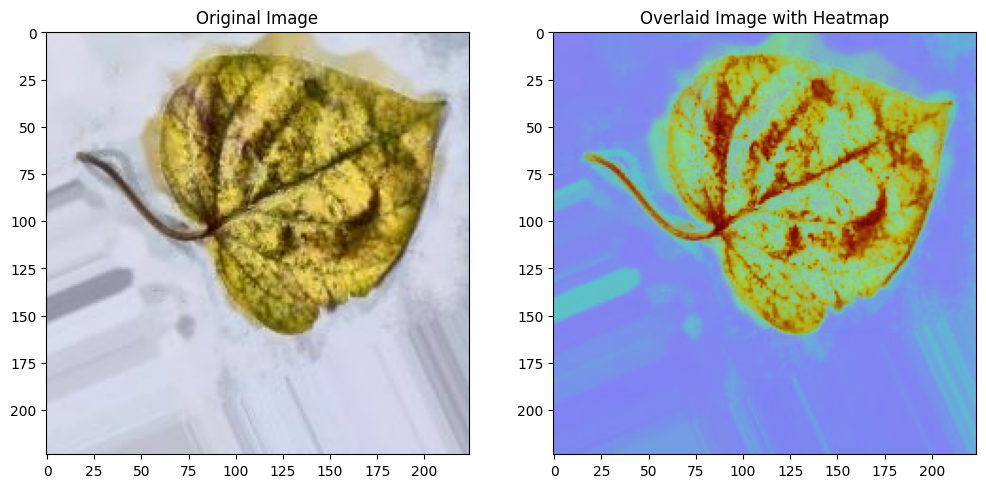

In [ ]:
img_path = '/kaggle/input/betal-leaf/Updated_aug/Dried Leaf/Dried_Leaf(10)_aug_0.jpg'
heatmap_path = '/kaggle/input/betal-leaf/Updated_aug/Dried Leaf/Dried_Leaf(10)_aug_0.jpg'
visualize_heatmap(img_path, heatmap_path)